<a href="https://colab.research.google.com/github/EikEUFS/Mestrado/blob/main/Rede_Neural_Perceptron_Multicamadas.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

<div align="center">
  <div style="display: flex; align-items: flex-start;">
    <img src="https://github.com/EikEUFS/Mestrado/blob/main/UFS.png?raw=true" alt="Logo da UFS" />
    <div style="display: flex; flex-direction: column;">    
      <h5> <strong> Eike Natan Sousa Brito - 07/04/2021</strong> </h5>
      <h5> Mestrando em Ciência da Computação na Universidade Federal de Sergipe </h5>
    </div>
  </div>
</div>



### Rede Neural Perceptron Multicamadas


Geralmente o ciclo de vida de um modelo de aprendizado profundo possui 5 etapas:

* Preparar os dados;
* Definir o modelo;
* Treinar o modelo;
* Avaliar o modelo;
* Fazer previsões.

Existe diversas maneiras de realizar cada uma dessas etapas utilizando o PyTorch, entretanto, meu objetivo é mostrar de forma simples cada uma delas.

## Importações


Foram utilizadas as importações:
* *Time* para calcular o tempo do treino.
* *Statistics* para calcular a média de arrays.
* *Numpy* e Pandas para trabalhar com os dados e *dataframes*.
* *Seaborn* para ilustração dos gráficos.
* *Pytorch* para o aprendizado de máquina.
* *Drive* para importar os arquivos do *google drive*.

In [1]:
from time import time

from statistics import mean as statisticsMean

from numpy import Inf
from numpy import floor

from numpy.random import shuffle

from pandas import read_csv

from seaborn import PairGrid
from seaborn import histplot
from seaborn import scatterplot

from torch import cuda
from torch import device
from torch import from_numpy
from torch import tensor
from torch import float32
from torch import max
from torch import sum
from torch import mean
from torch import save
from torch import load

from torch.nn import Module
from torch.nn import Linear
from torch.nn import Dropout
from torch.nn import ReLU
from torch.nn import Softmax
from torch.nn import Sigmoid

from torch.nn.functional import cross_entropy

from torch.optim import Adam
from torch.optim import SGD

from torch.utils.data import Dataset
from torch.utils.data import TensorDataset
from torch.utils.data import random_split
from torch.utils.data import DataLoader

from torch.nn.init import kaiming_uniform_
from torch.nn.init import xavier_uniform_

from torch.utils.data.sampler import SubsetRandomSampler

from google.colab import drive

## Utilizar CPU ou GPU ou TPU

Para melhorar o tempo de processamento o Google Colab fornece executar com outros tipos de processadores, por isso vamos utilizar a GPU do próprio Google. Para isso basta ir no menu Editar > Configurações de Notebook e no campo Acelerador de Hardware marcar a GPU e salvar.

```
No momento deverá mostrar a GPU Tesla T4
```

In [2]:
if cuda.is_available():    
  DEVICE = device("cuda")
  print('%d GPU(s) em uso.' % cuda.device_count())
  print('GPU utilizada:', cuda.get_device_name(0))
else:
  print('Não tem GPU em uso, por isso irá utilizar CPU.')
  DEVICE = device("cpu")

1 GPU(s) em uso.
GPU utilizada: Tesla T4


## Carregar, preparar e visualizar os dados


Foi criado uma classe (*CSVtoDataset*) para pegar os dados de um CSV de base Iris e deixa-los prontos para serem inseridos em um modelo.

O construtor recebe como parâmetro o caminho do arquivo CSV e organiza.

A função de **len** retorna o tamanho de dados que o CSV possui.

A função **get_item** recebe como parâmetro o indice desejado e retorna a linha do arquivo CSV.

A função **prepare_data** recebe como parâmetro os valores para separar os dados de treino, validação e teste respectivamente, devolvendo os valores no formato do pytorch.

A função **plot** mostra o gráfico de todas as características do CSV (sepal_length, sepal_width, petal_length, petal_width, species).

A função **characteristics** mostra o minimo e máximo de cada uma das caracteristicas de cada espécie.

In [3]:
class CSVtoDataset(Dataset):
  def __init__(self, path):
    # Denomina as colunas do arquivo
    cols = ["sepal_length", "sepal_width", "petal_length", "petal_width", "species"]

    # Abrir o arquivo CSV e transforma em um dataframe
    df = read_csv(path, sep=',', names=cols, encoding='utf-8', header=None)

    # Transforma a Iris-setosa em setosa, Iris-versicolor em versicolor e Iris-virginica em virginica
    df['species'] = df['species'].map({'Iris-setosa': 'setosa', 'Iris-versicolor': 'versicolor', 'Iris-virginica': 'virginica'})

    # Criar um rótulo para cada especie (setosa = 0, versicolor = 1, virginica = 2)
    species = list(df["species"].unique())
    df["label"] = df["species"].apply(species.index)

    # Separa nos dados de entrada e saida
    self.X = from_numpy(df[list(df.columns)[:-2]].to_numpy()).type(float32)
    self.y = tensor(df['label'])
    self.dataset = df

  def __len__(self):
    # Retorna a quantidade de dados do dataframe
    return len(self.X)

  def __getitem__(self, idx):
    # Retorna a linha selecionada
    return [self.X[idx], self.y[idx]]

  def prepare_data(self, split_train, split_valid, split_test, batch_size):
    data = TensorDataset(self.X, self.y)

    # Armazena a quantidade de dados de cada dado
    rows = list(self.X.shape)[0]
    train_size = int(split_train * rows)
    test_size = int(split_test * rows)

    # Pega a quantidade de dados randomicos
    train_data, test_data = random_split(data, [train_size, test_size])

    # Separa os dados de treinamento e validação
    num_train = len(train_data)
    idx = list(range(num_train))
    shuffle(idx)
    split = int(floor(split_valid * num_train))
    train_index, valid_index = idx[split:], idx[:split]

    train_sampler = SubsetRandomSampler(train_index)
    valid_sampler = SubsetRandomSampler(valid_index)

    # Converte os dados para o tipo necessario para o pytorch
    train_loader = DataLoader(train_data, batch_size = batch_size, sampler = train_sampler, num_workers = 0)
    valid_loader = DataLoader(train_data, batch_size = batch_size, sampler = valid_index, num_workers = 0)
    test_loader = DataLoader(test_data, batch_size  = batch_size, num_workers = 0)

    return train_loader, valid_loader, test_loader

  def plot(self):
    # Cria e plota os dados do dataset
    plt = PairGrid(self.dataset, hue="label")
    plt.map_diag(histplot)
    plt.map_offdiag(scatterplot)
    plt.add_legend()

  def characteristics(self):
    # Separa o dataframe de acordo com o label
    df_setosa = self.dataset.query('label==0')
    df_versicolor = self.dataset.query('label==1')
    df_virginica = self.dataset.query('label==2')

    # Imprime o minimo e maximo de cada specie
    print('SETOSA:')
    print(df_setosa['sepal_length'].min(), ' < sepal_length < ', df_setosa['sepal_length'].max())
    print(df_setosa['sepal_width'].min(), ' < sepal_width < ', df_setosa['sepal_width'].max())
    print(df_setosa['petal_length'].min(), ' < petal_length < ', df_setosa['petal_length'].max())
    print(df_setosa['petal_width'].min(), ' < petal_width < ', df_setosa['petal_width'].max())
    print()
    print('VERSICOLOR:')
    print(df_versicolor['sepal_length'].min(), ' < sepal_length < ', df_versicolor['sepal_length'].max())
    print(df_versicolor['sepal_width'].min(), ' < sepal_width < ', df_versicolor['sepal_width'].max())
    print(df_versicolor['petal_length'].min(), ' < petal_length < ', df_versicolor['petal_length'].max())
    print(df_versicolor['petal_width'].min(), ' < petal_width < ', df_versicolor['petal_width'].max())
    print()
    print('VIRGINICA:')
    print(df_virginica['sepal_length'].min(), ' < sepal_length < ', df_virginica['sepal_length'].max())
    print(df_virginica['sepal_width'].min(), ' < sepal_width < ', df_virginica['sepal_width'].max())
    print(df_virginica['petal_length'].min(), ' < petal_length < ', df_virginica['petal_length'].max())
    print(df_virginica['petal_width'].min(), ' < petal_width < ', df_virginica['petal_width'].max())

Os dados foram retirados no site da 
[ICS](https://archive.ics.uci.edu/ml/datasets/iris), onde foi retirado o dataset IRIS, muito famoso na literatura.

Caso não consiga acesar tambêm está o link do Google Drive desse projeto: 
[Google Drive](https://drive.google.com/file/d/13aQQNw62QFTSXrsgN0YYRFKl6DSXueQZ/view?usp=sharing)

In [4]:
# Código para abrir o Google Drive.
drive.mount("/content/drive")

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [5]:
''' Digite o caminho do seu arquivo'''
file_path = "/content/drive/MyDrive/Mestrado/Dissertacao/iris.data"

# Prepara os dados
dataset = CSVtoDataset(file_path)

Para poder analisar melhor os dados, foi utilizado a biblioteca seaborn, onde a mesma é capaz de plotar todos os dados do dataframe e analisar o quanto impacta a altura e largura da petala e da sepala. É possivel perceber nos graficos que cada especie possui caracteristicas em comum, e pode-se imaginar uma reta para cada uma das caracteristicas onde ele tem um limite minimo e maximo de cada característica de cada espécie.

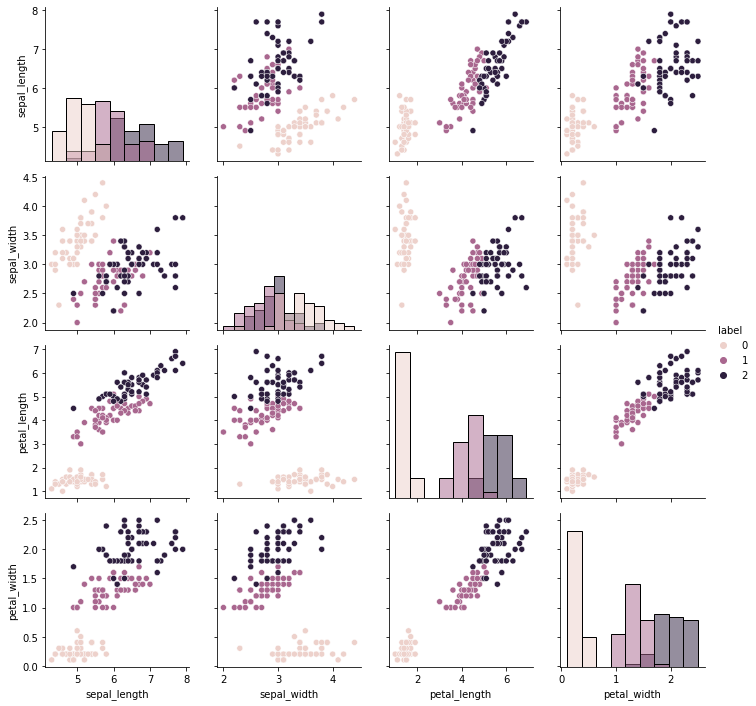

In [6]:
dataset.plot()

Para ficar melhor a visualização, foi impresso os valores minimos e maximos de cada especie, mostrando que cada uma das espécies tem características muito distintas uma das outras.

In [7]:
dataset.characteristics()

SETOSA:
4.3  < sepal_length <  5.8
2.3  < sepal_width <  4.4
1.0  < petal_length <  1.9
0.1  < petal_width <  0.6

VERSICOLOR:
4.9  < sepal_length <  7.0
2.0  < sepal_width <  3.4
3.0  < petal_length <  5.1
1.0  < petal_width <  1.8

VIRGINICA:
4.9  < sepal_length <  7.9
2.2  < sepal_width <  3.8
4.5  < petal_length <  6.9
1.4  < petal_width <  2.5


## Modelos

Aqui será responsável por criar as arquiteturas de todos os modelos. Para definir um modelo em PyTorch é necessário estender a classe *Module*.

O construtor de sua classe define as camadas que o modelo possui e função *forward* é a substituição que define como transmitir a propagação de entrada através das camadas definidas pelo construtor.


Explicação de alguns códigos:

* **Linear**: Uma camada que aplica a transformação linear ($\mathbf{y} = \mathbf{x} \mathbf{A} ^ \mathbf{T} + \mathbf{b}$).
* **Dropout**: Camada que tem a probabilidade de "desligar" algum neurônio durante o processo de treinamento, evitando o *overfitting*.
* **Criterion**: Função que calcula a função custo (*loss*). 
* **Optimizer**: Função que atualiza os parâmetros.
* **Activation**: Função de ativação, foi utilizado as funções *Softmax*, *Relu* e *Sigmoid*.
* **Xavier Uniform**: Define os pesos de uma camada para valores escolhidos a partir de uma distribuição uniforme aleatória de acordo com o tamanho da rede, da camada de entrada ou de saída.
* **Kaiming Uniform**: Define os pesos de uma camada para evitar que as saídas de ativação explodam ou desapareçam na função de ativação *ReLU*.

> Arquitetura da Rede *Net_Dropout*:
* **Entrada**: *Linear*(4, 8)
* **Saída**: *Linear*(8, 3)
* **Dropout**: *Entrada* (0.1)
* **Critério**: *Parâmetro*
* **Otimizador**: *Parâmetro*

In [8]:
class Net_Dropout(Module):
  def __init__(self, criterion_function, optimizer_function):
    super(Net_Dropout, self).__init__()
    self.linear1 = Linear(4, 8).to(DEVICE)

    self.drop = Dropout(0.1).to(DEVICE)

    self.linear2 = Linear(8, 3).to(DEVICE)

    self.criterion = criterion_function
    self.optimizer = optimizer_function

  def forward(self, X):
    X = self.linear1(X.to(DEVICE))

    X = self.drop(X.to(DEVICE))
    
    X = self.linear2(X.to(DEVICE))
    return X

> Arquitetura da Rede *Net_Sigmoid*:
* **Entrada**: *Linear*(4, 8)
* **Oculta**: *Linear*(8, 8)
* **Saída**: *Linear*(8, 3)
* **Sigmoid**: *Entrada* e *Oculta*
* **Critério**: *Parâmetro*
* **Otimizador**: *Parâmetro*

In [9]:
class Net_Sigmoid(Module):
  def __init__(self, criterion_function, optimizer_function):
    super(Net_Sigmoid, self).__init__()
    self.linear1 = Linear(4, 8).to(DEVICE)
    xavier_uniform_(self.linear1.weight)
    self.act1 = Sigmoid().to(DEVICE)

    self.linear2 = Linear(8, 8).to(DEVICE)
    xavier_uniform_(self.linear2.weight)
    self.act2 = Sigmoid().to(DEVICE)

    self.linear3 = Linear(8, 3).to(DEVICE)
    xavier_uniform_(self.linear3.weight)

    self.criterion = criterion_function
    self.optimizer = optimizer_function

  def forward(self, X):
    X = self.linear1(X)
    X = self.act1(X)

    X = self.linear2(X)
    X = self.act2(X)
    
    X = self.linear3(X)
    return X

> Arquitetura da Rede *Net_Relu*:
* **Entrada**: *Linear*(4, 8)
* **Oculta**: *Linear*(8, 8)
* **Saída**: *Linear*(8, 3)
* **ReLU**: *Entrada* e *Oculta*
* **Softmax**: *Saída*
* **Critério**: *Parâmetro*
* **Otimizador**: *Parâmetro*

In [10]:
class Net_Relu(Module):
  def __init__(self, criterion_function, optimizer_function):
    super(Net_Relu, self).__init__()
    self.linear1 = Linear(4, 8).to(DEVICE)
    kaiming_uniform_(self.linear1.weight, nonlinearity='relu')
    self.act1 = ReLU().to(DEVICE)
    self.linear2 = Linear(8, 8).to(DEVICE)
    kaiming_uniform_(self.linear2.weight, nonlinearity='relu')
    self.act2 = ReLU().to(DEVICE)
    self.linear3 = Linear(8, 3).to(DEVICE)
    xavier_uniform_(self.linear3.weight)
    self.act3 = Softmax(dim=1).to(DEVICE)

    self.criterion = criterion_function
    self.optimizer = optimizer_function

  def forward(self, X):
    X = self.linear1(X)
    X = self.act1(X)

    X = self.linear2(X)
    X = self.act2(X)
    
    X = self.linear3(X)
    X = self.act3(X)
    return X

## Funções de Treinamento e Predição

> **Training Step**: Cada entrada em um determinado lote (*batch*) é passada através dessa função, onde as saídas são comparadas com as metas para calcular e retornar o valor de perda (*loss*), esse valor de perda é calculado pela função *criterion*.

> Como é um problema de classificação foi utilizado a *entropia cruzada* em todos os casos.

In [11]:
def training_step(model, batch):
  # Separa os dados de entrada e o alvo e coloca para ser processado pela CPU, GPU ou TPU
  inputs, targets = batch
  inputs, targets = inputs.to(DEVICE), targets.to(DEVICE)

  # Retorna a saída
  outputs = model(inputs)

  # Avalia a diferença da saída com a meta
  loss = model.criterion(outputs, targets)

  # Retorna o valor de perda
  return loss

> **Validation Step**: Calcula o valor da perda que nem a função *training_step*, porém, pega o valor predito e calcula a acurácia (número de previsões corretas dividido pelo número total de previsões feitas).

> Foi utilizando o *.detach()* para definir que os gradientes não são necessários, para que os valores sejam excluídos do cálculo do gradiente, é o mesmo que fazer (*require_grad = False*). 

In [12]:
def validation_step(model, batch):
  # Separa os dados de entrada e o alvo e coloca para ser processado pela CPU, GPU ou TPU
  inputs, targets = batch
  inputs, targets = inputs.to(DEVICE), targets.to(DEVICE)

  # Retorna a saída
  outputs = model(inputs)

  # Avalia a diferença da saída com a meta
  loss = model.criterion(outputs, targets)

  # Armazena o valor predito
  _, pred = max(outputs, 1)

  # Calcula a acurácia
  accuracy_value = (pred == targets).float().sum()/len(pred)
  accuracy = accuracy_value.clone().detach()

  # Retorna o valor de perda e a acurácia
  return [loss.detach(), accuracy.detach()]

> **Evaluate**: Retorna o valor de perda e da acurácia do modelo.

In [13]:
def evaluate(model, loader):
  # Cálcula o valor de perda e da acúracia de cada lote
  outputs = [validation_step(model, batch) for batch in loader]

  # Converete o valor para Tensor
  outputs = tensor(outputs).T

  # Retorna a média de perda e acurácia do modelo
  loss, accuracy = mean(outputs, dim=1)
  
  return loss, accuracy

> **Fit**: Função para treinar o modelo.

> Para cada época, as perdas de cada lote do conjunto de treinamento são usadas para calcular o gradiente, em seguida o otimizador atualiza os parâmetros do modelo e redefine os gradientes para zero antes de passar para o próximo lote, justamente para que os gradientes não sejam acumulados.

> No final de cada época a perda de treinamento e validação são calculados no conjunto de validação.

In [14]:
def fit(model, train_loader, valid_loader, number_epochs, learning_rate, path_save = '', console = False):
  # Armazena o valor para infinito negativo
  valid_loss_min = Inf

  # Armazena os valores que vão ser retornados
  history = {"train_loss": [], "valid_loss": [], "accuracy": 0}

  # O otimizador selecionado pelo modelo
  optimizer = model.optimizer(model.parameters(), learning_rate)

  # Inicia o tempo do treino
  init_time = time()

  # Inicia as épocas
  for epoch in range(number_epochs):
    train_loss = 0
    valid_loss = 0

    # ---- Treinamento ---- #
    model.train()
    for batch in train_loader:
      
      optimizer.zero_grad()               # Zera o gradiente      
      loss = training_step(model, batch)  # Calcula a perda do modelo
      loss.backward()                     # Calcula o gradiente
      optimizer.step()                    # Atualiza os parâmetros

      # Armazena a perda do treinamento
      inputs, targets = batch
      train_loss += loss.item() * inputs.size(0)

    # ---- Validação ---- #
    model.eval()
    for batch in valid_loader:

      loss = training_step(model, batch)  # Calcula a perda do modelo

      # Armazena a perda da validação
      inputs, targets = batch
      valid_loss += loss.item() * inputs.size(0)   

    train_loss = train_loss / len(train_loader.sampler)
    valid_loss = valid_loss / len(valid_loader.sampler)

    # Armazena os valores de treino e validação
    history["train_loss"].append(train_loss)
    history["valid_loss"].append(valid_loss)      

    # Imprime se for necessário
    if (console):
      print("|----------------------[EPOCH {}]----------------------|".format(epoch+1))      
      print("| Train Loss: {:.6f} \t Valid Loss: {:.6f}".format(train_loss, valid_loss))

    # Salva se for necessário
    if (len(path_save) > 0 and valid_loss <= valid_loss_min):
      if (console):
        print('| Improved validation - ({:.6f} --> {:.6f}) - Save'.format(valid_loss_min, valid_loss))
      save_model(model, path_save)
      valid_loss_min = valid_loss  
  
  if (console):
    print("|------------------------------------------------------|".format(epoch+1))      

  # Finaliza o tempo do treino
  end_time = time()  

  # ---- Teste ---- #
  loss, accuracy = evaluate(model, test_loader) # Calcula a acurácia do modelo
  history["accuracy"] = accuracy                # Armazena o valor da acurácia

  # Imprime se for necessário
  if (console):
    print()
    print("########### Completed Training  ###########")
    print("Runtime: {:.2f}s".format(end_time - init_time))
    print("Loss: {:.6f} \t Accuracy: {:.6f}".format(loss.item(), accuracy.item()))
    print("###########################################")

  # Retorna o valor de perda de treino, validação e acurácia
  return history

> **Predict**: Recebe como parâmetro um array de tamanho 4 e retorna que tipo de espécie ele pertence a partir do modelo especificado.

In [15]:
def predict(model, data):
  data = Tensor([data])
  predict = model(data)
  predict = predict.detach().numpy()
  print('Predicted: %s (class=%d)' % (predict, argmax(predict)))
  return predict

> **Save Model**: Salva o modelo no caminho especificado.

In [16]:
def save_model(model, path_save):
  torch.save(model.state_dict(), path_save)

> **Load Model**: Carrega o modelo do caminho especificado.

In [17]:
def load_model(model, path_load):
  model.load_state_dict(load(path_load))

> **Mean ACC Model**: Cria 10 modelos de acordo com os parâmetros especificados e retorna a média da acurácia dos 10 modelos.

In [18]:
def mean_acc_model(net, criterion, optimizer, train_loader, valid_loader, batch_size, learning_rate):
  acc = []

  for _ in range(10):
    model = net(criterion, optimizer)
    history = fit(model, train_loader, valid_loader, batch_size, learning_rate)
    acc.append(history['accuracy'].item())

  return statisticsMean(acc)

## Criar e testar os modelos

> Foi separado os dados de treino, validação e teste para ser utilizado em todos o modelos.

> Sendo 80% dos dados para treino e 20% para teste.

> Dos 80% dos dados do treino, 20% dos dados foram separados para validação.

In [19]:
train_loader, valid_loader, test_loader = dataset.prepare_data(0.8, 0.2, 0.2, 20)

> Foi criado o modelo *Dropout* com a função de critério a *cross_entropy* e a função de otimização a *Adam*.

> Em seguida o modelo foi treinado com 10 épocas e a taxa de aprendizado de 1%, além de colocar para imprimir as informações necessárias.

> Foi impresso a perda de treino e validação de cada época e no final do treino imprime o tempo de execução, a taxa de perda do modelo e a acurácia do modelo.

In [20]:
model = Net_Dropout(cross_entropy, Adam)
history_model = fit(model, train_loader, valid_loader, 10, 0.1, '', True)

|----------------------[EPOCH 1]----------------------|
| Train Loss: 1.575965 	 Valid Loss: 0.888104
|----------------------[EPOCH 2]----------------------|
| Train Loss: 0.736064 	 Valid Loss: 0.595552
|----------------------[EPOCH 3]----------------------|
| Train Loss: 0.621494 	 Valid Loss: 0.477087
|----------------------[EPOCH 4]----------------------|
| Train Loss: 0.428096 	 Valid Loss: 0.328046
|----------------------[EPOCH 5]----------------------|
| Train Loss: 0.381835 	 Valid Loss: 0.314483
|----------------------[EPOCH 6]----------------------|
| Train Loss: 0.276191 	 Valid Loss: 0.196361
|----------------------[EPOCH 7]----------------------|
| Train Loss: 0.301702 	 Valid Loss: 0.155705
|----------------------[EPOCH 8]----------------------|
| Train Loss: 0.303963 	 Valid Loss: 0.205606
|----------------------[EPOCH 9]----------------------|
| Train Loss: 0.164551 	 Valid Loss: 0.104438
|----------------------[EPOCH 10]----------------------|
| Train Loss: 0.218334 	 

> Foi criado as redes *Dropout*, *Sigmoid* e *ReLU*, sendo cada um deles utilizando a função de critério a *cross_entropy* e a função de otimização a *Adam* e *SGD* em cada uma das redes.

> Por fim, foi retornado a média de cada uma das redes e impresso para avaliar o impacto de cada uma das redes com cada uma das funções.

In [22]:
print("Mean Accuracy - Model Dropout Adam: {:.6f}".format(mean_acc_model(Net_Dropout, cross_entropy, Adam, train_loader, valid_loader, 10, 0.1)))
print("Mean Accuracy - Model Dropout SGD: {:.6f}".format(mean_acc_model(Net_Dropout, cross_entropy, SGD, train_loader, valid_loader, 10, 0.1)))
print("Mean Accuracy - Model Sigmoid Adam: {:.6f}".format(mean_acc_model(Net_Sigmoid, cross_entropy, Adam, train_loader, valid_loader, 10, 0.1)))
print("Mean Accuracy - Model Sigmoid SGD: {:.6f}".format(mean_acc_model(Net_Sigmoid, cross_entropy, SGD, train_loader, valid_loader, 10, 0.1)))
print("Mean Accuracy - Model ReLU Adam: {:.6f}".format(mean_acc_model(Net_Relu, cross_entropy, Adam, train_loader, valid_loader, 10, 0.1)))
print("Mean Accuracy - Model ReLU SGD: {:.6f}".format(mean_acc_model(Net_Relu, cross_entropy, SGD, train_loader, valid_loader, 10, 0.1)))

Mean Accuracy - Model Dropout Adam: 0.952500
Mean Accuracy - Model Dropout SGD: 0.772500
Mean Accuracy - Model Sigmoid Adam: 0.917500
Mean Accuracy - Model Sigmoid SGD: 0.482500
Mean Accuracy - Model ReLU Adam: 0.522500
Mean Accuracy - Model ReLU SGD: 0.655000


> Foi rodado várias vezes esse código, para ver se houve uma diferença muito grande e foi visível que a rede *ReLU* obteve a menor acurácia dentre as outras redes, em ambas funções de otimização (*Adam* e *SGD*). A rede *Dropout* e *Sigmoid* com a função *Adam* obtiveram os melhores resultados dentre as outras redes com a acurácia acima de 90%, já a função de otimização *SGD* de ambas as redes obtiveram resultados muito abaixo dos dois melhores.

## Conclusão

> Cada rede funciona diferente para cada problema e é muito difícil dizer quais parâmetros são melhores para cada problema, normalmente esses parâmetros são testados até encontrar o que obteve melhor resultado e para esse problema da espécie iris a que obteve melhor resultado dentre essas redes foi as redes *Sigmoid* e *Dropout* com a função de otimização *Adam*, porém, não quer dizer que essa é a melhor rede que existe.